In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data token-label


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
base = '/content/drive/MyDrive/NLP_Spring403/Tamrin3/part2-processed'
# Load the CSV files for train, validation, and test sets
train_data = pd.read_csv(base + '/train_data.csv')
val_data = pd.read_csv(base + '/val_data.csv')
test_data = pd.read_csv(base + '/test_data.csv')

# Separate features (Entity Text) and labels (Label)
train_texts, train_labels = train_data['Entity Text'].astype(str), train_data['Label']
val_texts, val_labels = val_data['Entity Text'].astype(str), val_data['Label']
test_texts, test_labels = test_data['Entity Text'].astype(str), test_data['Label']

In [ ]:
train_data

,Entity Text,Label
0,acetominophen,Drug
1,20mg,Strength
2,40mg,Strength
3,pain,Reason
4,pain,Reason
...,...,...
37698,Capsule,Form
37699,seizures,Reason
37700,Tramadol,Drug
37701,Cholestyramine-Sucrose,Drug


In [ ]:
train_labels[0]

'Drug'

In [ ]:
# Convert labels to categorical labels (one-hot encoding)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_seq_length = 10
max_words = 4000

tag_tokenizer = Tokenizer(filters='', lower=False)
tag_tokenizer.fit_on_texts(train_labels)
train_labels = tag_tokenizer.texts_to_sequences(train_labels)
test_labels = tag_tokenizer.texts_to_sequences(test_labels)
val_labels = tag_tokenizer.texts_to_sequences(val_labels)

y_train = pad_sequences(train_labels, maxlen=max_seq_length, padding='post')
y_val = pad_sequences(val_labels, maxlen=max_seq_length, padding='post')
y_test = pad_sequences(test_labels, maxlen=max_seq_length, padding='post')

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
m_tags = len(tag_tokenizer.word_index) + 1
# Pad sequences to ensure uniform length

train_data_pad = pad_sequences(train_sequences, maxlen=max_seq_length, padding='post')
val_data_pad = pad_sequences(val_sequences, maxlen=max_seq_length, padding='post')
test_data_pad = pad_sequences(test_sequences, maxlen=max_seq_length, padding='post')

In [ ]:
y_test.shape

(4713, 10)

In [ ]:
train_data_pad[0]

# Our LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_seq_length))
model.add(LSTM(units=50, return_sequences=True))
model.add(TimeDistributed(Dense(m_tags, activation='softmax')))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary)

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7a098666ba60>>


In [ ]:
batch_size = 32
epochs = 20

history = model.fit(train_data_pad, y_train,
                    validation_data=(val_data_pad, y_val),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/20
1179/1179 [==============================] - 18s 13ms/step - loss: 0.2196 - accuracy: 0.9365 - val_loss: 0.0523 - val_accuracy: 0.9844
Epoch 2/20
1179/1179 [==============================] - 14s 12ms/step - loss: 0.0323 - accuracy: 0.9914 - val_loss: 0.0252 - val_accuracy: 0.9927
Epoch 3/20
1179/1179 [==============================] - 14s 12ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0210 - val_accuracy: 0.9928
Epoch 4/20
1179/1179 [==============================] - 15s 13ms/step - loss: 0.0146 - accuracy: 0.9951 - val_loss: 0.0201 - val_accuracy: 0.9929
Epoch 5/20
1179/1179 [==============================] - 15s 13ms/step - loss: 0.0133 - accuracy: 0.9953 - val_loss: 0.0203 - val_accuracy: 0.9924
Epoch 6/20
1179/1179 [==============================] - 15s 13ms/step - loss: 0.0128 - accuracy: 0.9954 - val_loss: 0.0200 - val_accuracy: 0.9925
Epoch 7/20
1179/1179 [==============================] - 15s 13ms/step - loss: 0.0125 - accuracy: 0.9954 - val_loss: 0.0199 -

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_data_pad)

# Convert predictions to categorical labels
pred_labels = np.argmax(predictions, axis=-1)

# Flatten the true and predicted labels
true_labels_flat = y_test.flatten()
pred_labels_flat = pred_labels.flatten()
print(true_labels_flat.shape, pred_labels_flat.shape)
# Remove padding labels from true and predicted labels
mask = true_labels_flat != 0
true_labels_filtered = true_labels_flat[mask]
pred_labels_filtered = pred_labels_flat[mask]

# Convert indices back to labels
index_to_label = {v: k for k, v in tag_tokenizer.word_index.items()}
index_to_label[0] = 'O'  # Assuming 'O' is for 'Other' or 'Outside' entities

# Print classification report
label_names = [index_to_label[i] for i in range(1, len(index_to_label))]

print("Classification Report:")
print(classification_report(true_labels_filtered, pred_labels_filtered, target_names=label_names))

# Generate confusion matrix
conf_mat = confusion_matrix(true_labels_filtered, pred_labels_filtered)

# Print the confusion matrix with labels
print("Confusion Matrix:")
print("Labels:", label_names)
print(conf_mat)

148/148 [==============================] - 1s 3ms/step
(47130,) (47130,)
Classification Report:
              precision    recall  f1-score   support

        Drug       1.00      0.95      0.97      1559
    Strength       0.91      0.91      0.91       640
        Form       0.98      0.98      0.98       637
       Route       0.98      0.97      0.98       550
   Frequency       0.99      0.95      0.97       475
      Dosage       0.84      0.84      0.84       363
      Reason       0.67      0.89      0.76       343
         ADE       0.61      0.57      0.59        91
    Duration       0.95      0.75      0.84        55

    accuracy                           0.93      4713
   macro avg       0.88      0.87      0.87      4713
weighted avg       0.94      0.93      0.93      4713

Confusion Matrix:
Labels: ['Drug', 'Strength', 'Form', 'Route', 'Frequency', 'Dosage', 'Reason', 'ADE', 'Duration']
[[1476    0    1    0    1    0   79    2    0]
 [   1  583    0    0    0   42   1

In [ ]:
specific_test_file = base + '/100035.csv'  # Specific test file to evaluate
specific_test_data = pd.read_csv(specific_test_file)
specific_test_texts, specific_test_labels = specific_test_data['Entity Text'].astype(str), specific_test_data['Label']
specific_test_labels_seq = tag_tokenizer.texts_to_sequences(specific_test_labels)
y_specific_test = pad_sequences(specific_test_labels_seq, maxlen=max_seq_length, padding='post')
specific_test_sequences = tokenizer.texts_to_sequences(specific_test_texts)
specific_test_data_pad = pad_sequences(specific_test_sequences, maxlen=max_seq_length, padding='post')


predictions = model.predict(specific_test_data_pad)
predicted_labels = [tag_tokenizer.sequences_to_texts([pred.argmax(axis=-1)]) for pred in predictions]

# Convert sequences back to labels for printing
true_labels = tag_tokenizer.sequences_to_texts(specific_test_labels_seq)

# Print results in the desired format
print("{:25}||{:15}||{}".format("Entity Text", "True Label", "Predicted Label"))
for text, true, pred in zip(specific_test_texts, true_labels, predicted_labels):
    print("{:25}||{:15}||{:15}||{}".format(text, true, pred[0], str(true == pred[0])))

# Previous model

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_seq_length),
    LSTM(units=256, return_sequences=True),
    TimeDistributed(Dense(units=m_tags, activation='softmax'))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 10

history = model.fit(train_data_pad, y_train,
                    validation_data=(val_data_pad, y_val),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/10
1179/1179 [==============================] - 70s 57ms/step - loss: 0.1135 - accuracy: 0.9650 - val_loss: 0.0259 - val_accuracy: 0.9922
Epoch 2/10
1179/1179 [==============================] - 64s 54ms/step - loss: 0.0191 - accuracy: 0.9937 - val_loss: 0.0201 - val_accuracy: 0.9923
Epoch 3/10
1179/1179 [==============================] - 62s 53ms/step - loss: 0.0143 - accuracy: 0.9950 - val_loss: 0.0200 - val_accuracy: 0.9932
Epoch 4/10
1179/1179 [==============================] - 63s 53ms/step - loss: 0.0132 - accuracy: 0.9952 - val_loss: 0.0194 - val_accuracy: 0.9933
Epoch 5/10
1179/1179 [==============================] - 61s 52ms/step - loss: 0.0128 - accuracy: 0.9951 - val_loss: 0.0193 - val_accuracy: 0.9933
Epoch 6/10
1179/1179 [==============================] - 69s 58ms/step - loss: 0.0124 - accuracy: 0.9954 - val_loss: 0.0192 - val_accuracy: 0.9937
Epoch 7/10
1179/1179 [==============================] - 66s 56ms/step - loss: 0.0122 - accuracy: 0.9953 - val_loss: 0.0195 -

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_data_pad)

# Convert predictions to categorical labels
pred_labels = np.argmax(predictions, axis=-1)

# Flatten the true and predicted labels
true_labels_flat = y_test.flatten()
pred_labels_flat = pred_labels.flatten()
print(true_labels_flat.shape, pred_labels_flat.shape)
# Remove padding labels from true and predicted labels
mask = true_labels_flat != 0
true_labels_filtered = true_labels_flat[mask]
pred_labels_filtered = pred_labels_flat[mask]

# Convert indices back to labels
index_to_label = {v: k for k, v in tag_tokenizer.word_index.items()}
index_to_label[0] = 'O'  # Assuming 'O' is for 'Other' or 'Outside' entities

# Print classification report
label_names = [index_to_label[i] for i in range(1, len(index_to_label))]

print("Classification Report:")
print(classification_report(true_labels_filtered, pred_labels_filtered, target_names=label_names))

# Generate confusion matrix
conf_mat = confusion_matrix(true_labels_filtered, pred_labels_filtered)

# Print the confusion matrix with labels
print("Confusion Matrix:")
print("Labels:", label_names)
print(conf_mat)

148/148 [==============================] - 4s 20ms/step
(47130,) (47130,)
Classification Report:
              precision    recall  f1-score   support

        Drug       0.94      0.99      0.97      1559
    Strength       0.91      0.91      0.91       640
        Form       0.98      0.98      0.98       637
       Route       0.98      0.97      0.98       550
   Frequency       0.99      0.95      0.97       475
      Dosage       0.84      0.85      0.84       363
      Reason       0.84      0.77      0.80       343
         ADE       0.62      0.48      0.54        91
    Duration       0.95      0.71      0.81        55

    accuracy                           0.93      4713
   macro avg       0.89      0.85      0.87      4713
weighted avg       0.93      0.93      0.93      4713

Confusion Matrix:
Labels: ['Drug', 'Strength', 'Form', 'Route', 'Frequency', 'Dosage', 'Reason', 'ADE', 'Duration']
[[1543    0    1    0    1    0   14    0    0]
 [  14  583    0    0    0   42   

In [ ]:
specific_test_file = base + '/100035.csv'  # Specific test file to evaluate
specific_test_data = pd.read_csv(specific_test_file)
specific_test_texts, specific_test_labels = specific_test_data['Entity Text'].astype(str), specific_test_data['Label']
specific_test_labels_seq = tag_tokenizer.texts_to_sequences(specific_test_labels)
y_specific_test = pad_sequences(specific_test_labels_seq, maxlen=max_seq_length, padding='post')
specific_test_sequences = tokenizer.texts_to_sequences(specific_test_texts)
specific_test_data_pad = pad_sequences(specific_test_sequences, maxlen=max_seq_length, padding='post')


predictions = model.predict(specific_test_data_pad)
predicted_labels = [tag_tokenizer.sequences_to_texts([pred.argmax(axis=-1)]) for pred in predictions]

# Convert sequences back to labels for printing
true_labels = tag_tokenizer.sequences_to_texts(specific_test_labels_seq)

# Print results in the desired format
print("{:25}||{:15}||{}".format("Entity Text", "True Label", "Predicted Label"))
for text, true, pred in zip(specific_test_texts, true_labels, predicted_labels):
    print("{:25}||{:15}||{:15}||{}".format(text, true, pred[0], str(true == pred[0])))

9/9 [==============================] - 0s 12ms/step
Entity Text              ||True Label     ||Predicted Label
recurrent seizures       ||Reason         ||Reason         ||True
ativan                   ||Drug           ||Drug           ||True
IM                       ||Route          ||Route          ||True
Topiramate               ||Drug           ||Drug           ||True
25mg                     ||Strength       ||Strength       ||True
PO                       ||Route          ||Route          ||True
BID                      ||Frequency      ||Frequency      ||True
PM                       ||Duration       ||Frequency      ||False
50mg                     ||Strength       ||Strength       ||True
po                       ||Route          ||Route          ||True
BID                      ||Frequency      ||Frequency      ||True
for seven days           ||Duration       ||Duration       ||True
ongoing                  ||Frequency      ||Frequency      ||True
vancomycin               ||Dr

# BiLSTM-CRF

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git -q
!pip install sklearn-crfsuite -q
!pip install seqeval -q
!pip install tensorflow-addons -q

  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model
from tensorflow.keras.layers import Input
#from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text import text_to_word_sequence
import pickle

In [ ]:

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode


class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim)
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
base = '/content/drive/MyDrive/NLP_Spring403/Tamrin3/n2c2/part2'
# Load the CSV files for train, validation, and test sets
train_data = pd.read_csv(base + '/train.csv')
val_data = pd.read_csv(base + '/val.csv')
test_data = pd.read_csv(base + '/test.csv')

In [ ]:
# Function to split sentences and tags into rows
def split_sentence_tags(row):
    words = row['Text'].split()
    tags = row['Label'].split()
    sentence_num = f"Sentence: {row.name + 1}"
    return pd.DataFrame({'Sentence #': [sentence_num] * len(words), 'Word': words, 'Tag': tags})

# Apply the function and concatenate the results
df = pd.concat(train_data.apply(split_sentence_tags, axis=1).values).reset_index(drop=True)


In [ ]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, t) for w, t in zip(s['Word'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]

    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [ ]:
# Create an instance of the Sentence class
getter = sentence(df)

# Display one full sentence
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'Admission Date: [**2200-5-18**] Discharge Date: [**2200-5-30**] Date of Birth: [**2140-12-2**] Sex: M Service: MEDICINE Allergies: Patient recorded as having No'

In [ ]:
#sentence with its pos and tag.
sent = getter.get_text()
print(sent)

[('Admission', 'O'), ('Date:', 'O'), ('[**2200-5-18**]', 'O'), ('Discharge', 'O'), ('Date:', 'O'), ('[**2200-5-30**]', 'O'), ('Date', 'O'), ('of', 'O'), ('Birth:', 'O'), ('[**2140-12-2**]', 'O'), ('Sex:', 'O'), ('M', 'O'), ('Service:', 'O'), ('MEDICINE', 'O'), ('Allergies:', 'O'), ('Patient', 'O'), ('recorded', 'O'), ('as', 'O'), ('having', 'O'), ('No', 'O')]


In [ ]:
sentences = getter.sentences


In [ ]:
# Number of data points passed in each iteration
batch_size = 64
# Passes through entire dataset
epochs = 8
# Maximum length of review
max_len = 75
# Dimension of embedding vector
embedding = 40

In [ ]:
#Getting unique words and labels from data
words = list(df['Word'].unique())
tags = list(df['Tag'].unique())
# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [ ]:
print("The word Admission is identified by the index: {}".format(word_to_index["Admission"]))
print("The label O for the organization is identified by the index: {}".format(tag_to_index["O"]))

The word Admission is identified by the index: 2
The label O for the organization is identified by the index: 1


In [ ]:
# Converting each sentence into list of index from list of tokens
X = [[word_to_index[w[0]] for w in s] for s in sentences]

# Padding each sequence to have same length  of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

In [ ]:
# Convert label to index
y = [[tag_to_index[w[1]] for w in s] for s in sentences]

# padding
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

In [ ]:
num_tag = df['Tag'].nunique()
# One hot encoded labels
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)


In [ ]:
print("Size of training input data : ", X_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", X_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (19377, 75)
Size of training output data :  (19377, 75, 11)
Size of testing input data :  (3420, 75)
Size of testing output data :  (3420, 75, 11)


In [ ]:
# Let's check the first sentence before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[0] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', X[0])

*****Before Processing first sentence : *****
 Admission Date: [**2200-5-18**] Discharge Date: [**2200-5-30**] Date of Birth: [**2140-12-2**] Sex: M Service: MEDICINE Allergies: Patient recorded as having No
*****After Processing first sentence : *****
  [ 2  3  4  5  3  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


In [ ]:
# First label before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[1] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', y[0])

*****Before Processing first sentence : *****
 O O O O O O O O O O O O O O O O O O O O
*****After Processing first sentence : *****
  [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [

In [ ]:
num_tags = df['Tag'].nunique()
# Model architecture
input = Input(shape = (max_len,))
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len, mask_zero = True)(input)
model = Bidirectional(LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(num_tags+1, activation="relu"))(model)
crf = CRF(num_tags+1, sparse_target=True)
out = crf(model)
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss, metrics=[crf.accuracy])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 75, 40)            1944000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 75, 100)           36400     
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 75, 11)            1111      
 stributed)                                                      
                                                                 
 crf_1 (CRF)                 (None, 75, 11)            121       
                                                                 
Total params: 1981632 (7.56 MB)
Trainable params: 1981632 (

In [ ]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

In [ ]:
history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1, callbacks=[checkpointer])

Epoch 1/8
273/273 [==============================] - 99s 317ms/step - loss: 156.1753 - viterbi_accuracy: 0.2269 - val_loss: 171.8321 - val_viterbi_accuracy: 0.2409
Epoch 2/8
273/273 [==============================] - 88s 322ms/step - loss: 121.1670 - viterbi_accuracy: 0.4266 - val_loss: 84.8023 - val_viterbi_accuracy: 0.9858
Epoch 3/8
273/273 [==============================] - 87s 318ms/step - loss: 90.5001 - viterbi_accuracy: 0.9879 - val_loss: 59.4451 - val_viterbi_accuracy: 0.9735
Epoch 4/8
273/273 [==============================] - 86s 317ms/step - loss: 61.4463 - viterbi_accuracy: 0.9908 - val_loss: 41.1612 - val_viterbi_accuracy: 0.7349
Epoch 5/8
273/273 [==============================] - 87s 319ms/step - loss: 34.4437 - viterbi_accuracy: 0.9921 - val_loss: 33.6156 - val_viterbi_accuracy: 0.7349
Epoch 6/8
273/273 [==============================] - 87s 320ms/step - loss: 14.1126 - viterbi_accuracy: 0.9931 - val_loss: 33.8783 - val_viterbi_accuracy: 0.7349
Epoch 7/8
273/273 [======

In [ ]:
history.history.keys()


dict_keys(['loss', 'viterbi_accuracy', 'val_loss', 'val_viterbi_accuracy'])

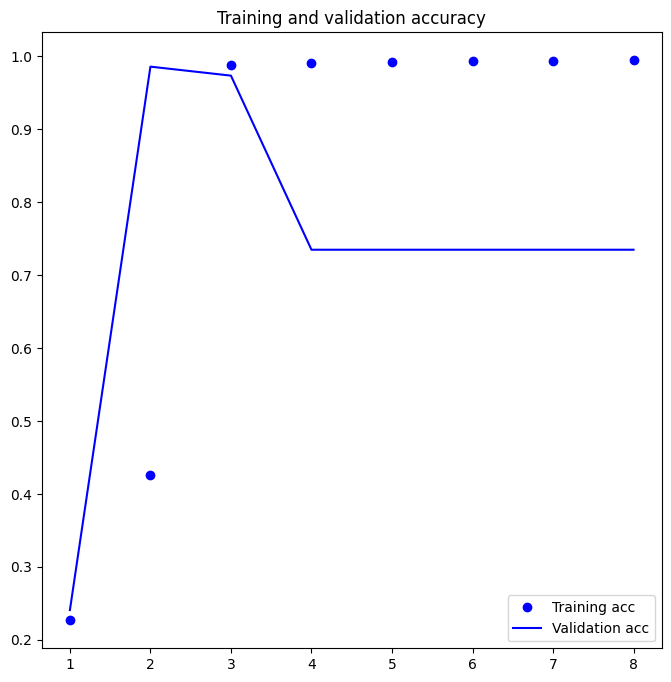

In [ ]:
acc = history.history['viterbi_accuracy']
val_acc = history.history['val_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

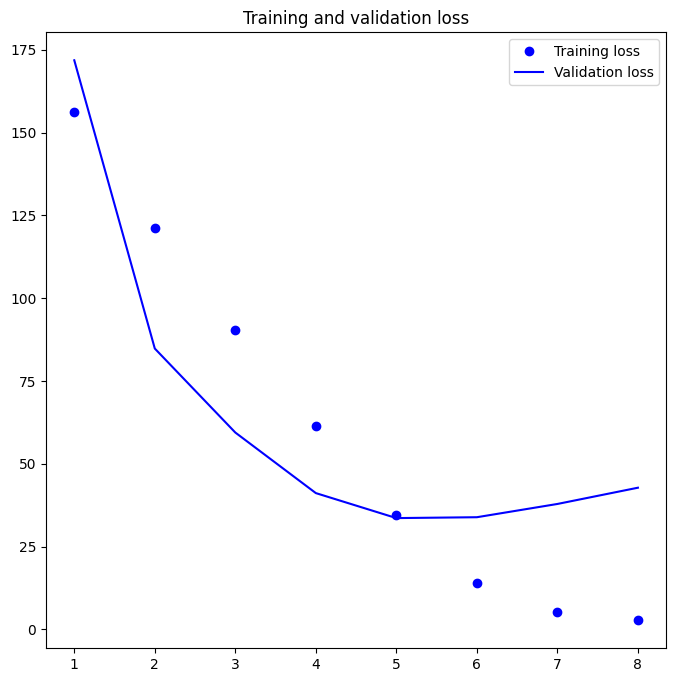

In [ ]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

107/107 [==============================] - 10s 67ms/step


In [ ]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true]

In [ ]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))


F1-score is : 89.1%


In [ ]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

         ADE       0.00      0.00      0.00       172
      Dosage       0.94      0.90      0.92       803
        Drug       0.87      0.84      0.85      2182
    Duration       0.80      0.53      0.63       186
        Form       0.96      0.92      0.94       998
   Frequency       0.89      0.93      0.91      1748
           O       0.98      0.99      0.98     59058
         PAD       1.00      1.00      1.00    188447
      Reason       0.57      0.32      0.41       730
       Route       0.97      0.91      0.94       709
    Strength       0.96      0.95      0.96      1467

    accuracy                           0.99    256500
   macro avg       0.81      0.75      0.78    256500
weighted avg       0.99      0.99      0.99    256500



In [ ]:
# At every execution model picks some random test sample from test set.
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)b
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

1/1 [==============================] - 0s 40ms/step
Sample number 1964 of 3420 (Test Set)
Word           ||True ||Pred
celecoxib      : Drug  O
for            : O     O
musculoskeletal: Reason Reason
pain           : Reason Reason
but            : O     O
this           : O     O
was            : O     O
held           : O     O
over           : O     O
the            : O     O
concern        : O     O
of             : O     O
possible       : O     O
upper          : O     O
gastrointestinal: O     O
bleeding       : O     O
in             : O     O
the            : O     O
setting        : O     O
of             : O     O


In [ ]:
with open('word_to_index.pickle', 'wb') as f:
    pickle.dump(word_to_index, f)

with open('tag_to_index.pickle', 'wb') as f:
    pickle.dump(tag_to_index, f)